# Imports

In [1]:
import sys
sys.path.append('/home/jovyan/work')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Importar utilitários customizados
from src import S3Client, DatabaseClient

# Configurações de visualização
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

import warnings
warnings.filterwarnings('ignore')

# Carregamento dos Dados

## Conectar ao MinIO

In [2]:
# Conectar ao MinIO
s3 = S3Client()

INFO:src.s3_utils:S3 Client inicializado: http://minio:9000/ml-bucket-heart


In [3]:
# Listar arquivos disponíveis
print("📋 Arquivos no MinIO:")
files = s3.list_files()
for f in files:
    print(f"   - {f}")

# %% Carregar dataset bruto
df = s3.read_csv('raw/heart.csv')

print(f"\n✅ Dataset carregado!")
print(f"📊 Shape: {df.shape[0]} linhas, {df.shape[1]} colunas")

INFO:src.s3_utils:📋 4 arquivos encontrados com prefixo ''
INFO:src.s3_utils:✅ CSV lido: s3://ml-bucket-heart/raw/heart.csv (1190 linhas)


📋 Arquivos no MinIO:
   - processed/test.csv
   - processed/train.csv
   - processed/validation.csv
   - raw/heart.csv

✅ Dataset carregado!
📊 Shape: 1190 linhas, 12 colunas


# Visão Geral dos Dados

## Informações Básicas

In [4]:
print("\n--- Primeiras 5 Linhas: ---")
display(df.head())


--- Primeiras 5 Linhas: ---


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [5]:
print("\n--- Informações do DataFrame: ---")
df.info()


--- Informações do DataFrame: ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB


In [6]:
print(f"\n📊 O DataFrame tem {df.shape[0]} linhas e {df.shape[1]} colunas.")
print(f"\n📋 Colunas: {list(df.columns)}")


📊 O DataFrame tem 1190 linhas e 12 colunas.

📋 Colunas: ['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol', 'fasting blood sugar', 'resting ecg', 'max heart rate', 'exercise angina', 'oldpeak', 'ST slope', 'target']


In [7]:
print("\n--- Resumo Estatístico: ---")
display(df.describe())


--- Resumo Estatístico: ---


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
count,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,53.720168,0.763866,3.232773,132.153782,210.363866,0.213445,0.698319,139.732773,0.387395,0.922773,1.624370,0.528571
std,9.358203,0.424884,0.935480,18.368823,101.420489,0.409912,0.870359,25.517636,0.487360,1.086337,0.610459,0.499393
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,188.000000,0.000000,0.000000,121.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,229.000000,0.000000,0.000000,140.500000,0.000000,0.600000,2.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,269.750000,0.000000,2.000000,160.000000,1.000000,1.600000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000


In [8]:
print("\n--- Tipos de Dados: ---")
print(df.dtypes)


--- Tipos de Dados: ---
age                      int64
sex                      int64
chest pain type          int64
resting bp s             int64
cholesterol              int64
fasting blood sugar      int64
resting ecg              int64
max heart rate           int64
exercise angina          int64
oldpeak                float64
ST slope                 int64
target                   int64
dtype: object


## Análise da Qualidade dos Dados

### Valores Nulos

In [9]:
print("\n--- Avaliação dos Valores Nulos: ---")
null_counts = df.isnull().sum()
display(null_counts[null_counts > 0] if null_counts.sum() > 0 else "✅ Nenhum valor nulo encontrado!")


--- Avaliação dos Valores Nulos: ---


'✅ Nenhum valor nulo encontrado!'

### Duplicatas

In [10]:
print("\n--- Avaliação dos Registros Duplicados: ---")
n_duplicates = df.duplicated().sum()
print(f"Total de linhas duplicadas: {n_duplicates} ({n_duplicates/len(df)*100:.2f}%)")

if n_duplicates > 0:
    print("\n⚠️ ATENÇÃO: Dataset tem 272 duplicatas (23% dos dados)!")
    print("Serão removidas no pré-processamento.")


--- Avaliação dos Registros Duplicados: ---
Total de linhas duplicadas: 272 (22.86%)

⚠️ ATENÇÃO: Dataset tem 272 duplicatas (23% dos dados)!
Serão removidas no pré-processamento.


### Valores Impossíves

In [11]:
def detectar_valores_impossiveis(df):
    """
    Ranges fisiológicos baseados em guidelines médicas (AHA, NIH, ACC)
    """
    ranges = {
        "age": (18, 100),
        "resting bp s": (60, 260),
        "cholesterol": (70, 900),
        "max heart rate": (30, 260),
        "oldpeak": (-3.0, 7.0)
    }
    
    resultados = {}
    
    for col, (lo, hi) in ranges.items():
        impossiveis = df[(df[col] < lo) | (df[col] > hi)]
        resultados[col] = {
            "total_impossiveis": len(impossiveis),
            "percentual": len(impossiveis) / len(df) * 100,
            "indices": impossiveis.index.tolist()[:10],  # Primeiros 10
            "valores": impossiveis[col].tolist()[:10]
        }
    
    return resultados

In [12]:
print("\n--- Detecção de Valores Impossíveis: ---")
resultados = detectar_valores_impossiveis(df)

for col, info in resultados.items():
    print(f"\n==== {col} ====")
    print(f"Total impossíveis: {info['total_impossiveis']} ({info['percentual']:.2f}%)")
    if info['total_impossiveis'] > 0:
        print(f"Exemplos: {info['valores']}")

print("\n⚠️ PRINCIPAIS PROBLEMAS IDENTIFICADOS:")
print("   1. resting bp s = 0 (1 registro)")
print("   2. cholesterol = 0 (172 registros = 14.45%!)")
print("   → Serão substituídos pela mediana no pré-processamento")


--- Detecção de Valores Impossíveis: ---

==== age ====
Total impossíveis: 0 (0.00%)

==== resting bp s ====
Total impossíveis: 1 (0.08%)
Exemplos: [0]

==== cholesterol ====
Total impossíveis: 172 (14.45%)
Exemplos: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

==== max heart rate ====
Total impossíveis: 0 (0.00%)

==== oldpeak ====
Total impossíveis: 0 (0.00%)

⚠️ PRINCIPAIS PROBLEMAS IDENTIFICADOS:
   1. resting bp s = 0 (1 registro)
   2. cholesterol = 0 (172 registros = 14.45%!)
   → Serão substituídos pela mediana no pré-processamento


### Outliers

In [13]:
def detect_outliers_iqr(df, column):
    """Detecta outliers usando método IQR"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()

In [14]:
print("\n--- Avaliação dos Outliers (IQR): ---")
numeric_features = df.select_dtypes(include=[np.number]).columns.drop('target')

outlier_summary = {}
for col in numeric_features:
    n_outliers = detect_outliers_iqr(df, col)
    if n_outliers > 0:
        outlier_summary[col] = n_outliers

if outlier_summary:
    print("Outliers detectados por feature:")
    for col, count in outlier_summary.items():
        print(f"  - {col}: {count} outliers")
else:
    print("Nenhum outlier extremo detectado")

print("\n💡 Nota: Outliers serão mantidos pois são fisiologicamente possíveis")


--- Avaliação dos Outliers (IQR): ---
Outliers detectados por feature:
  - sex: 281 outliers
  - chest pain type: 66 outliers
  - resting bp s: 37 outliers
  - cholesterol: 193 outliers
  - fasting blood sugar: 254 outliers
  - max heart rate: 1 outliers
  - oldpeak: 11 outliers

💡 Nota: Outliers serão mantidos pois são fisiologicamente possíveis


# Visualizações

## Outliers por Target

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

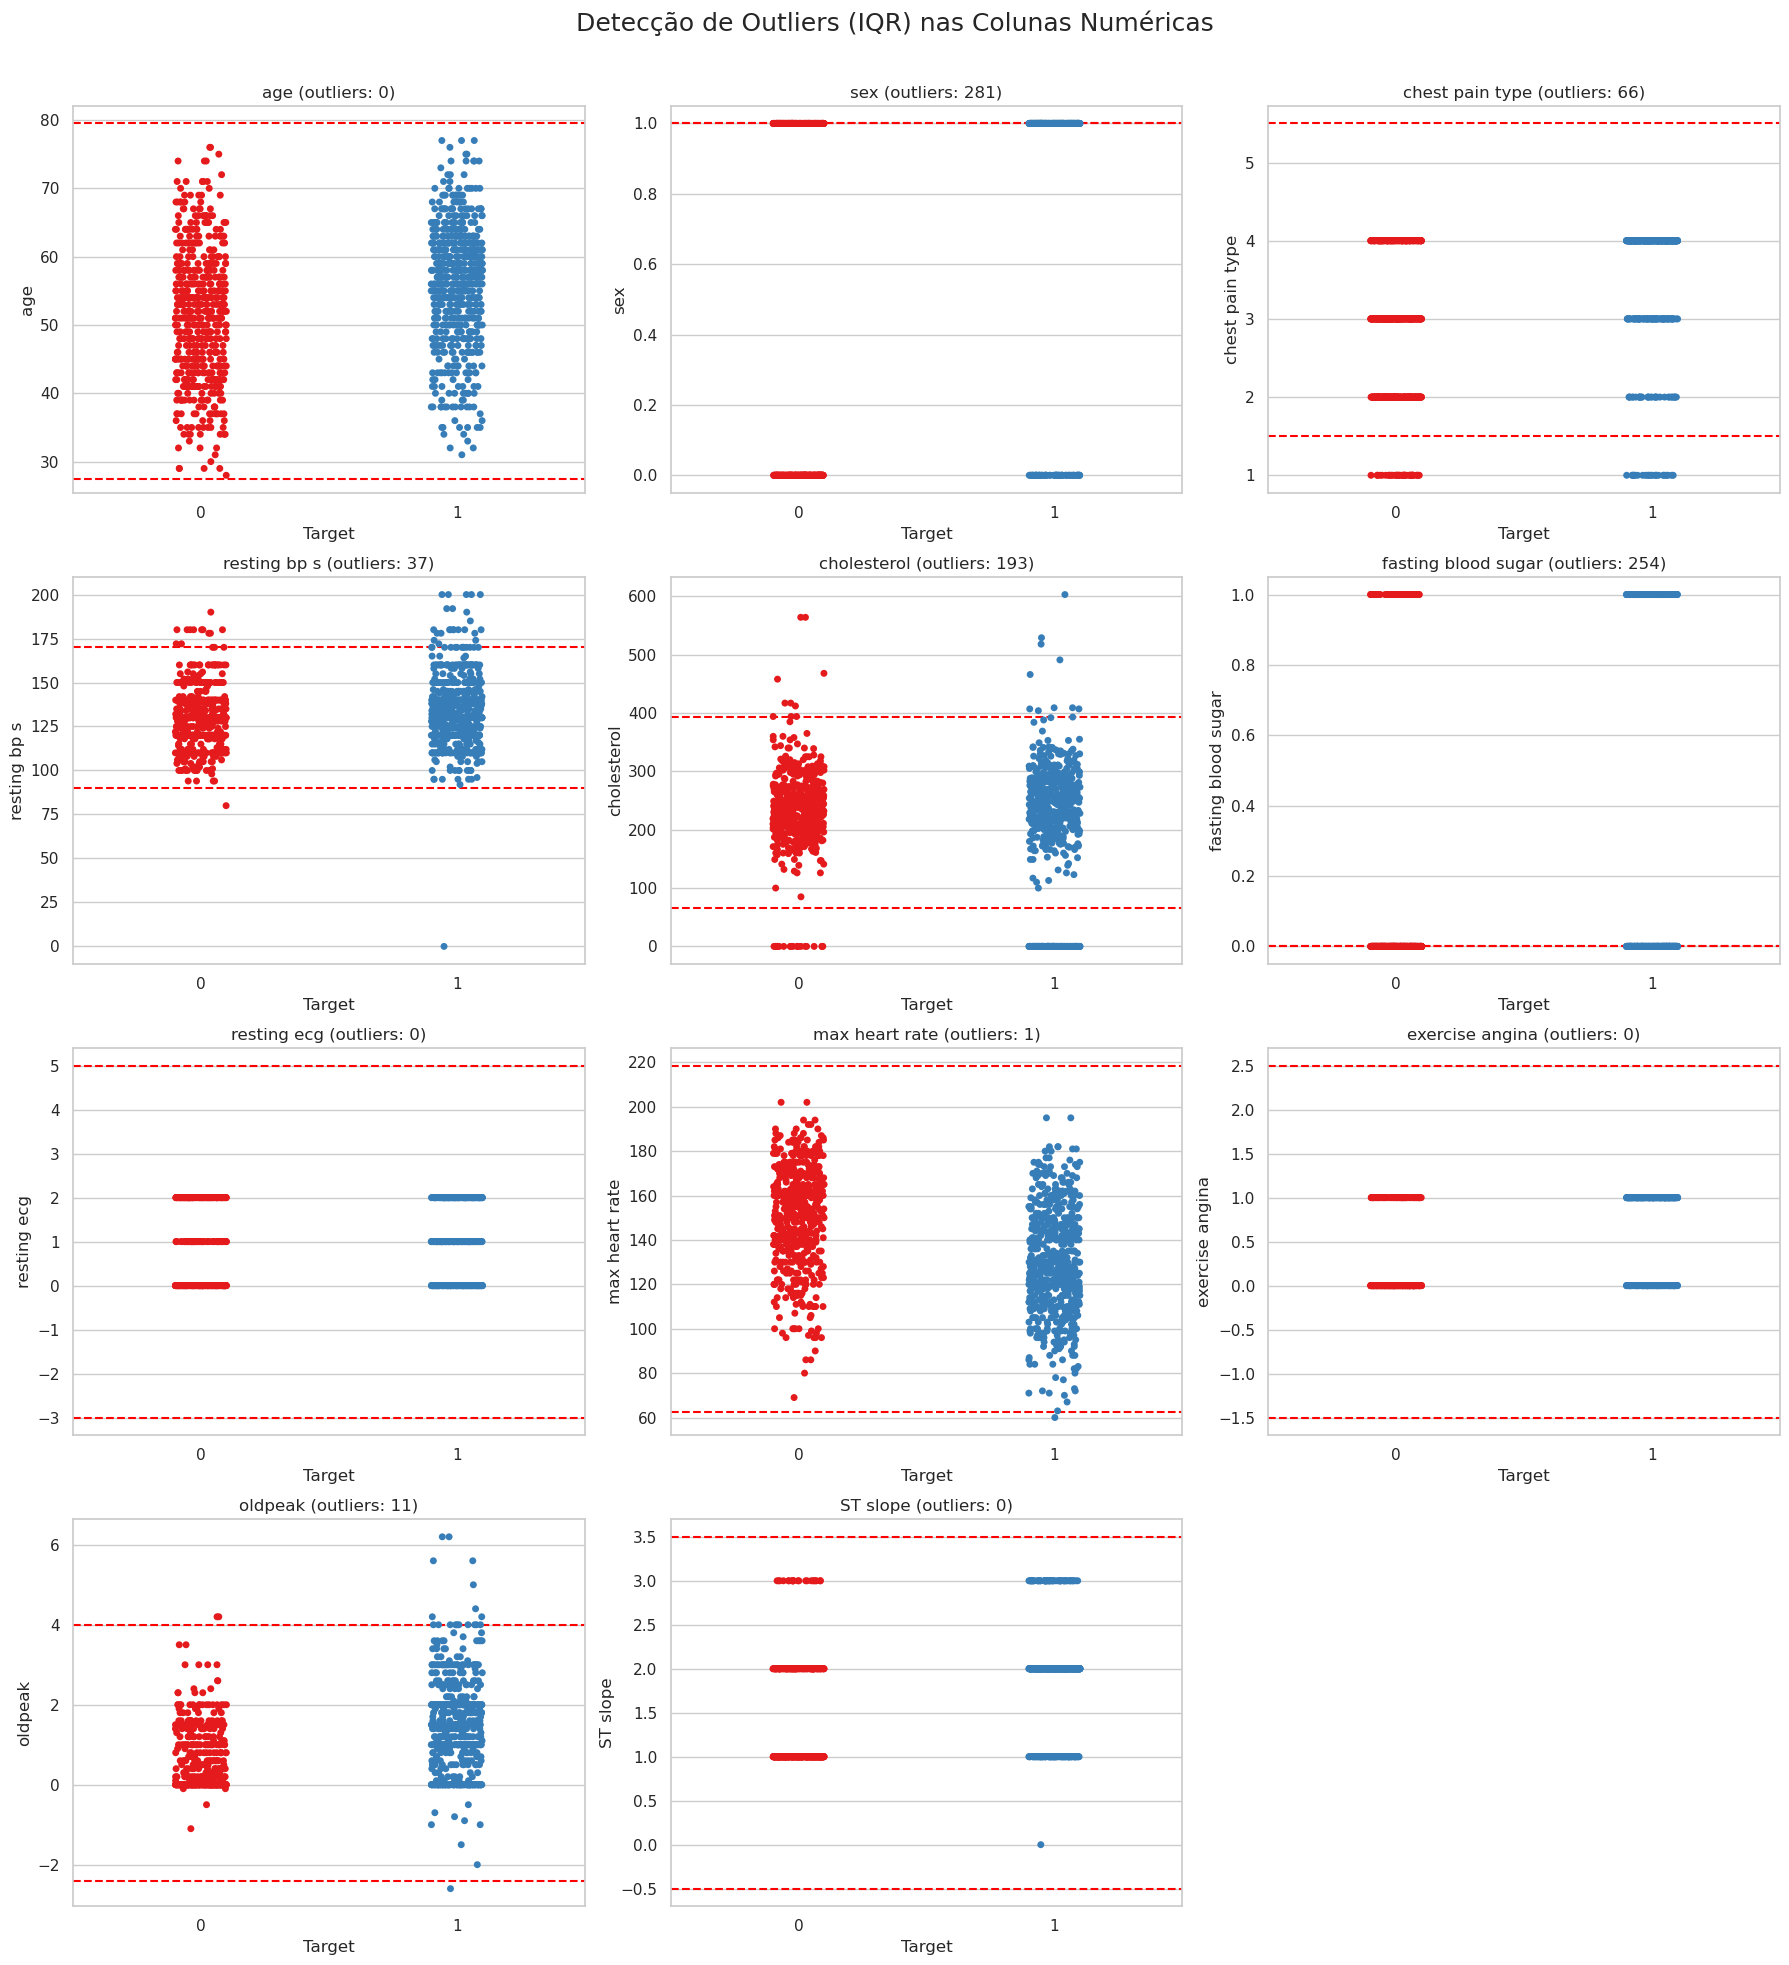

In [15]:
TARGET_COLUMN = 'target'
numeric_cols = [c for c in df.select_dtypes(include='number').columns if c != TARGET_COLUMN]

n_cols = 3 
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

plt.figure(figsize=(n_cols * 6, n_rows * 5))
plt.suptitle("Detecção de Outliers (IQR) nas Colunas Numéricas", fontsize=18)

for i, col in enumerate(numeric_cols, 1):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers_df = df[(df[col] < lower) | (df[col] > upper)]
    
    plt.subplot(n_rows, n_cols, i)
    
    sns.stripplot(
        x=TARGET_COLUMN, 
        y=col, 
        data=df, 
        hue=TARGET_COLUMN, 
        palette="Set1", 
        jitter=True,
        legend=False
    )
    
    plt.axhline(upper, color="red", linestyle="--", label="IQR Upper")
    plt.axhline(lower, color="red", linestyle="--", label="IQR Lower")
    
    plt.title(f"{col} (outliers: {len(outliers_df)})")
    plt.xlabel("Target")
    plt.ylabel(col)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## Distribuição da Variável Alvo


--- Distribuição das Classes do Target ---


,Contagem,Percentual (%)
target,,
1,629,52.86
0,561,47.14


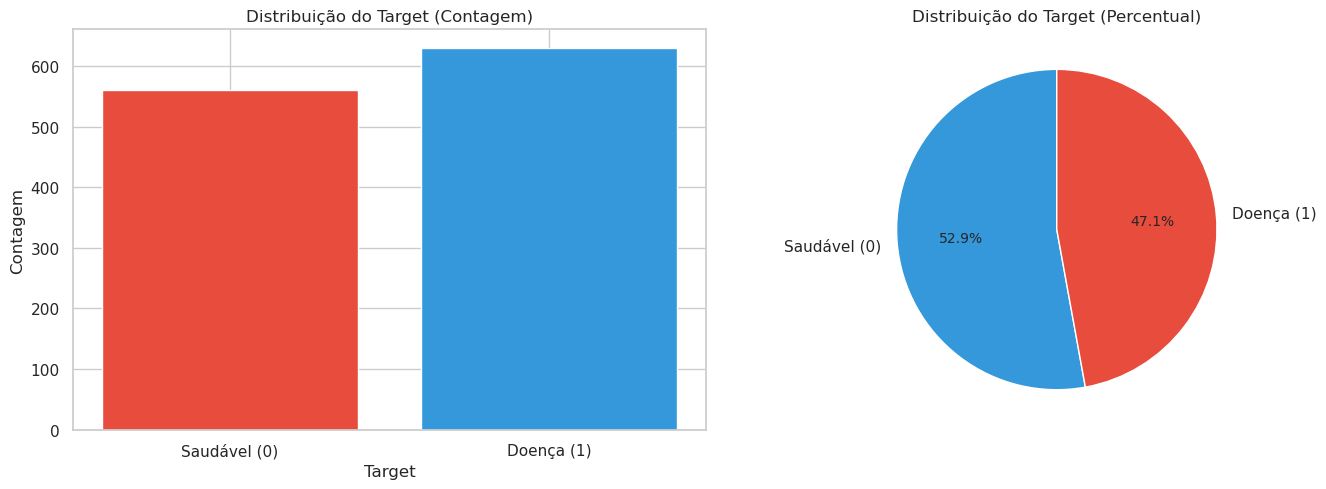

In [16]:
print("\n--- Distribuição das Classes do Target ---")
target_counts = df["target"].value_counts()
target_percent = df["target"].value_counts(normalize=True) * 100

target_df = pd.DataFrame({
    "Contagem": target_counts,
    "Percentual (%)": target_percent.round(2)
})

display(target_df)

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Contagem
axes[0].bar(target_counts.index, target_counts.values, color=['#3498db', '#e74c3c'])
axes[0].set_xlabel('Target')
axes[0].set_ylabel('Contagem')
axes[0].set_title('Distribuição do Target (Contagem)')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Saudável (0)', 'Doença (1)'])

# Percentual
axes[1].pie(target_counts.values, labels=['Saudável (0)', 'Doença (1)'], 
            autopct='%1.1f%%', colors=['#3498db', '#e74c3c'], startangle=90)
axes[1].set_title('Distribuição do Target (Percentual)')

plt.tight_layout()
plt.show()

## Análise Univariada - Distribuições

### Distribuições das features numéricas

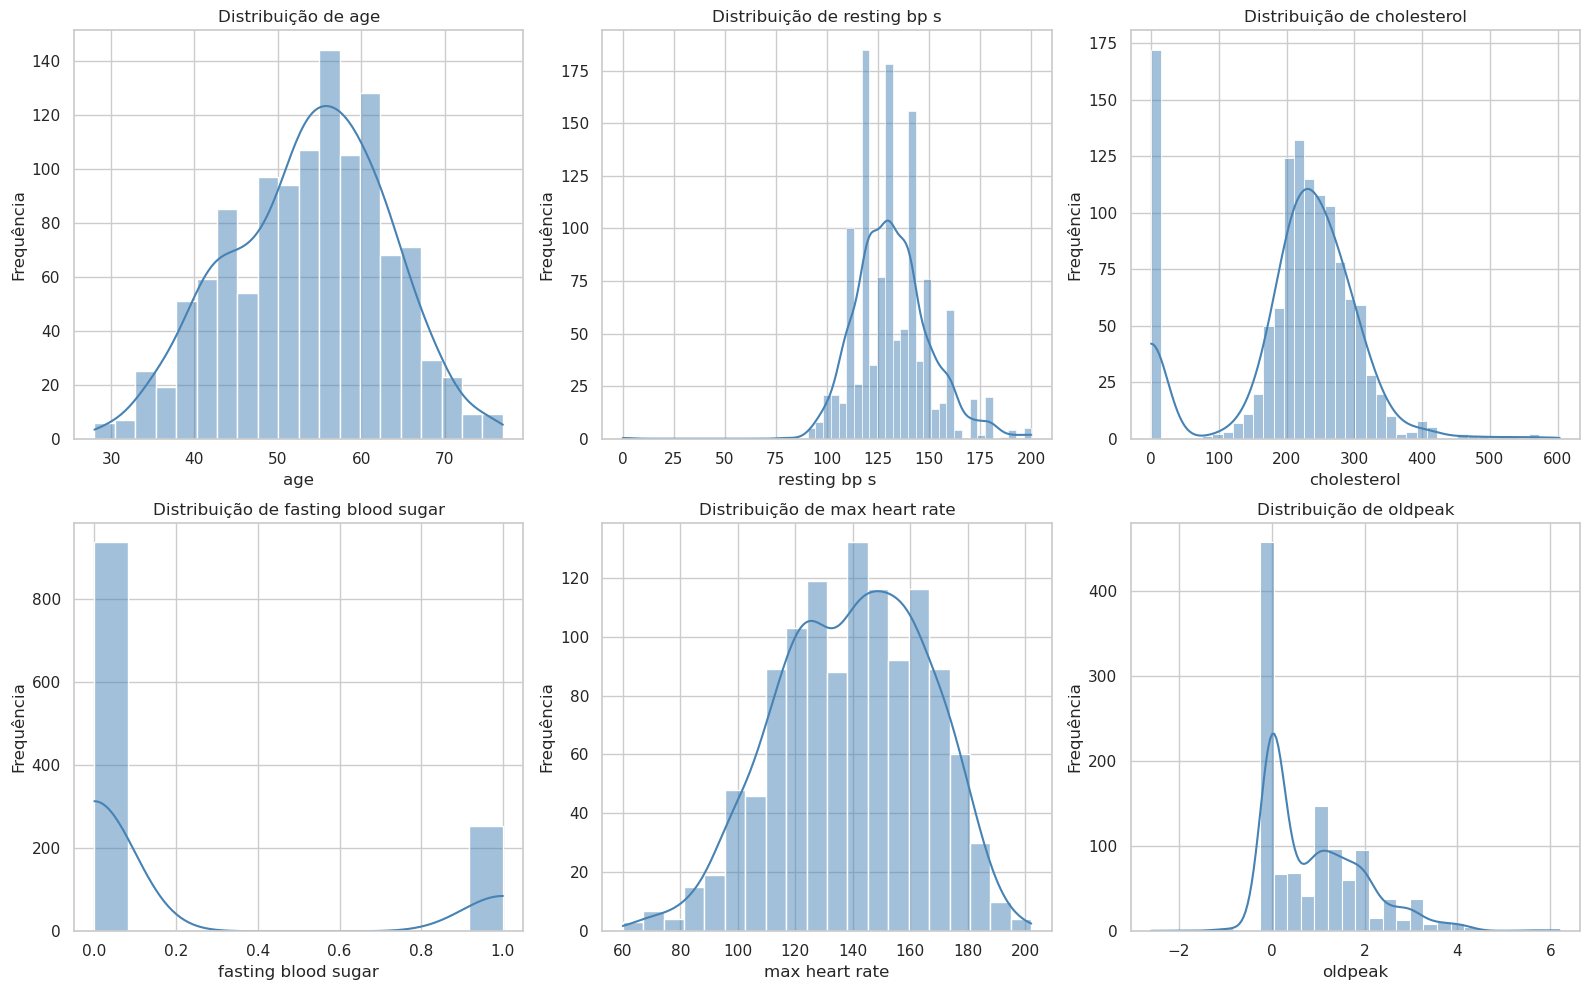

In [17]:
numerical_cols = ["age", "resting bp s", "cholesterol", 
                  "fasting blood sugar", "max heart rate", "oldpeak"]

plt.figure(figsize=(16, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True, color='steelblue')
    plt.title(f"Distribuição de {col}")
    plt.xlabel(col)
    plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

### Features binárias

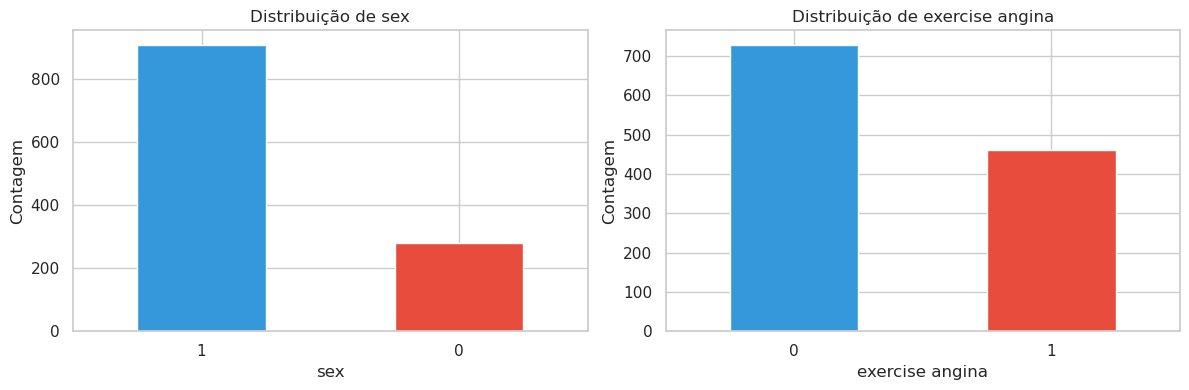

In [18]:
binary_cols = ["sex", "exercise angina"]

plt.figure(figsize=(12, 4))
for i, col in enumerate(binary_cols, 1):
    plt.subplot(1, 2, i)
    df[col].value_counts().plot(kind='bar', color=['#3498db', '#e74c3c'])
    plt.title(f"Distribuição de {col}")
    plt.xlabel(col)
    plt.ylabel("Contagem")
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Features categóricas

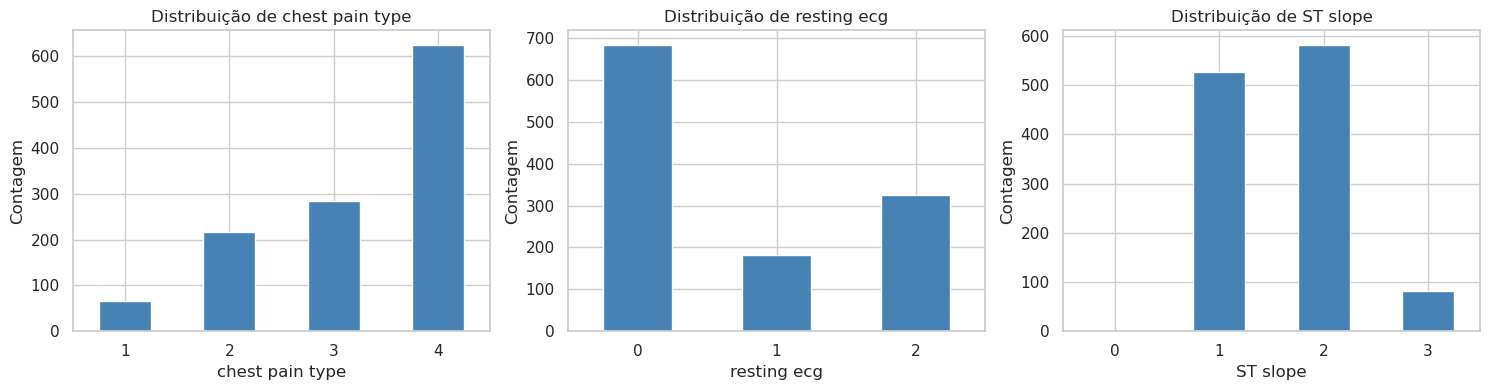

In [19]:
categorical_cols = ["chest pain type", "resting ecg", "ST slope"]

plt.figure(figsize=(15, 4))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(1, 3, i)
    df[col].value_counts().sort_index().plot(kind='bar', color='steelblue')
    plt.title(f"Distribuição de {col}")
    plt.xlabel(col)
    plt.ylabel("Contagem")
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Análise de Correlação

### Matriz de correlação completa

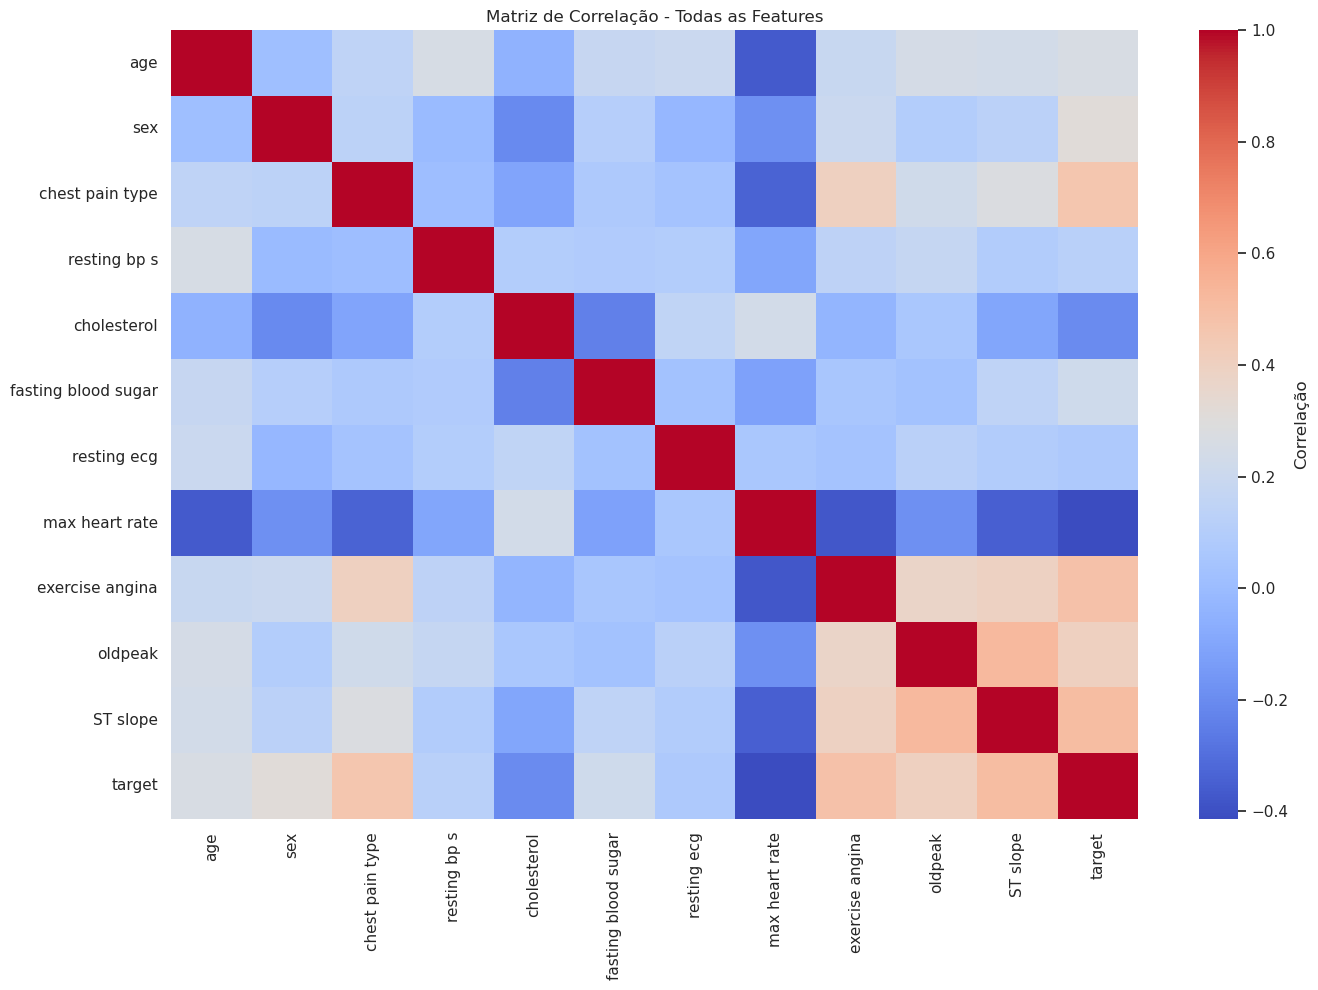

In [20]:
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False, cbar_kws={'label': 'Correlação'})
plt.title("Matriz de Correlação - Todas as Features")
plt.tight_layout()
plt.show()

### Correlação entre features numéricas

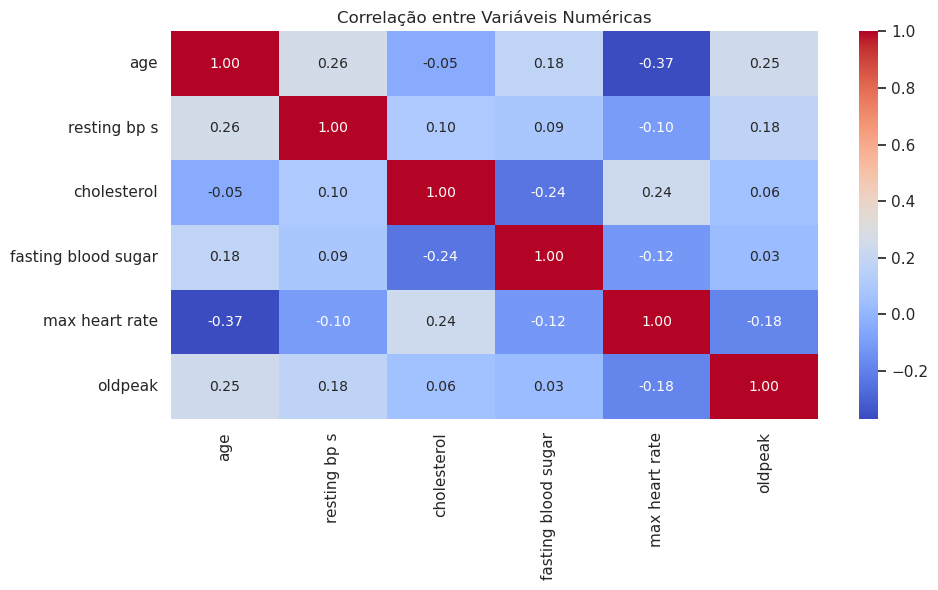

In [21]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[numerical_cols].corr(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title("Correlação entre Variáveis Numéricas")
plt.tight_layout()
plt.show()

### Correlação com o target

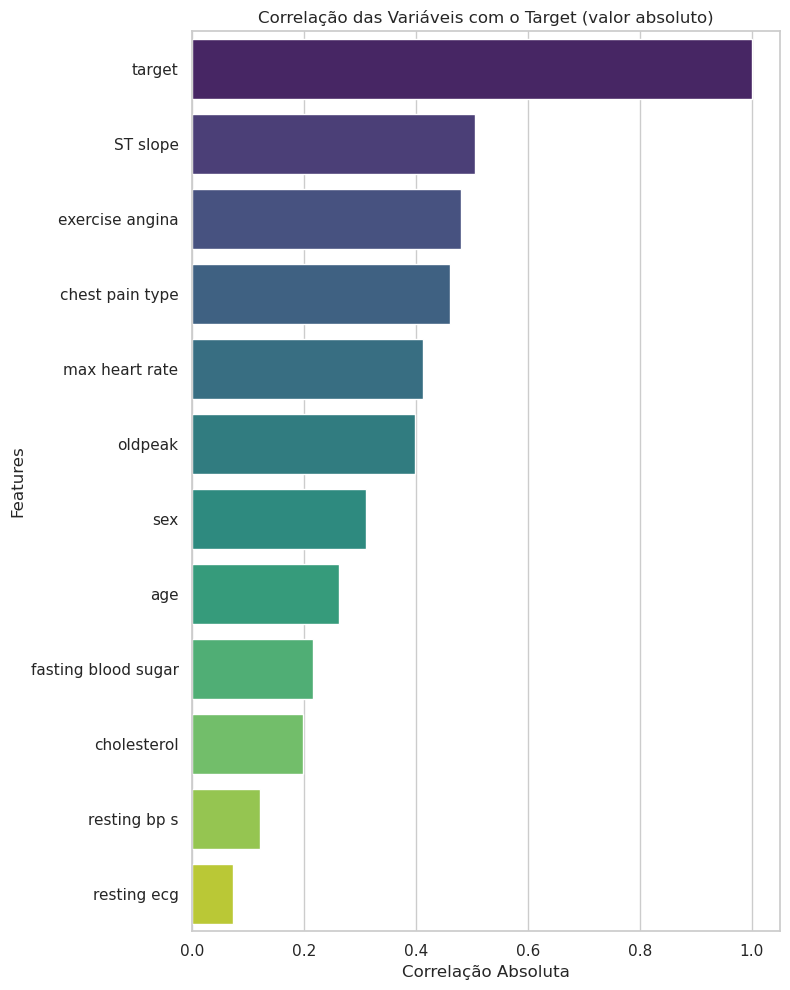


🔝 Top 5 features mais correlacionadas com target:


target             1.000000
ST slope           0.505608
exercise angina    0.481467
chest pain type    0.460127
max heart rate     0.413278
oldpeak            0.398385
Name: target, dtype: float64

In [22]:
corr_with_target = df.corr()["target"].abs().sort_values(ascending=False)

plt.figure(figsize=(8, 10))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='viridis')
plt.title("Correlação das Variáveis com o Target (valor absoluto)")
plt.xlabel("Correlação Absoluta")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

print("\n🔝 Top 5 features mais correlacionadas com target:")
display(corr_with_target.head(6))

## Análise Bivariada - Features vs Target

### Boxplots por target

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

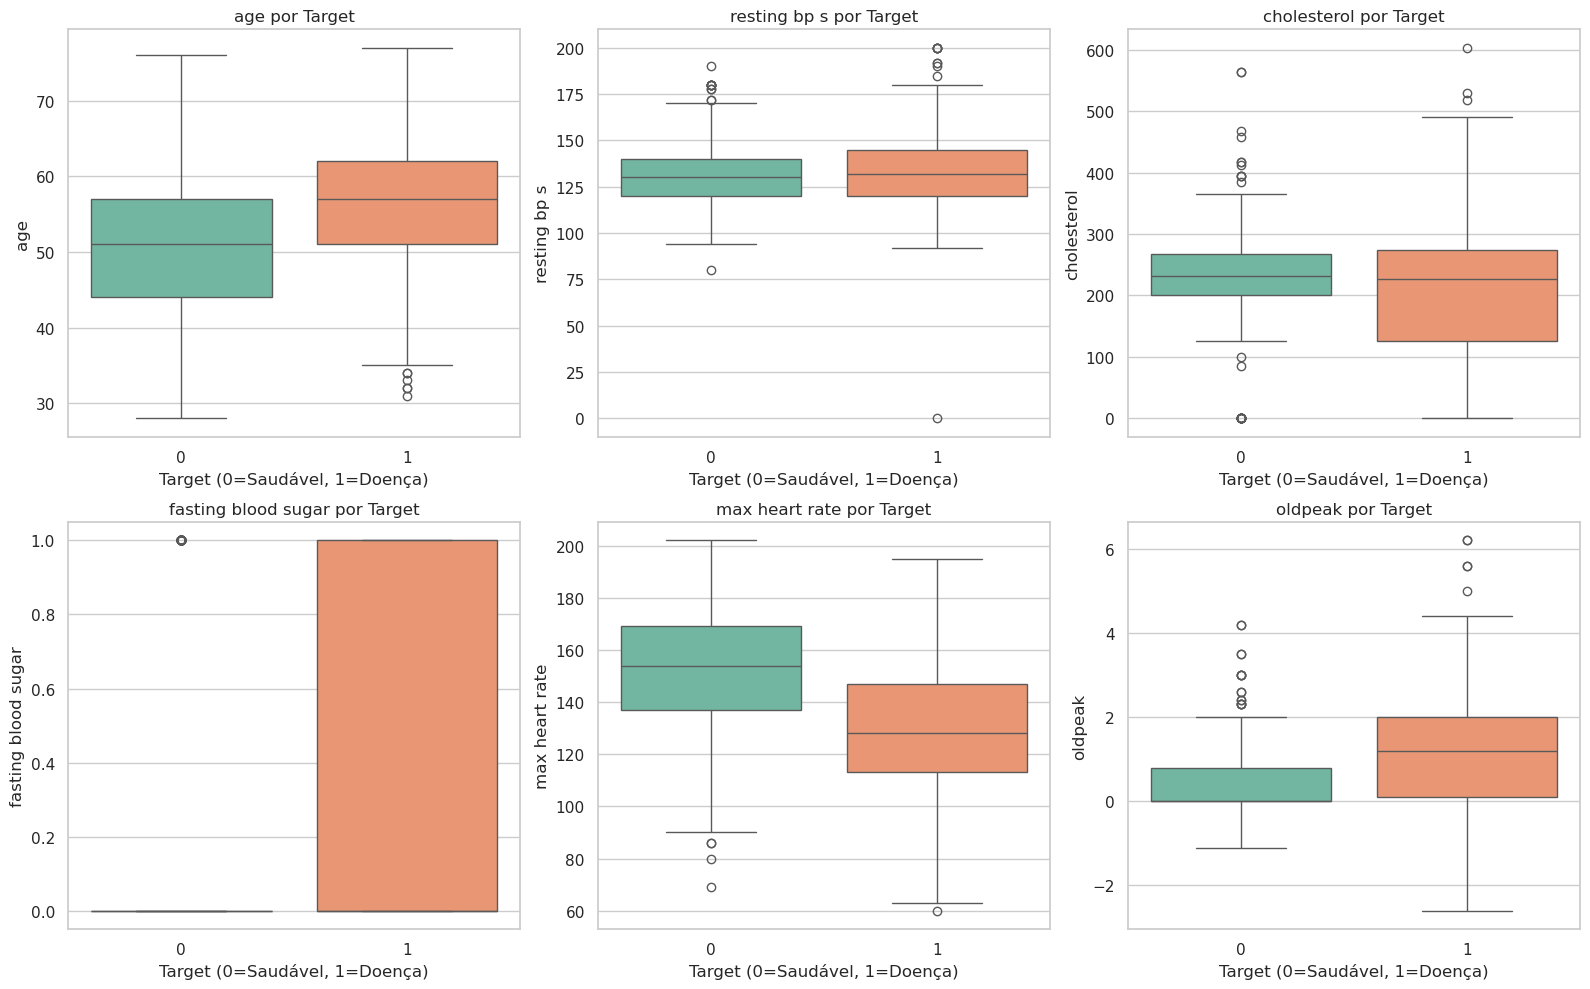

In [23]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x="target", y=col, data=df, palette="Set2")
    plt.title(f"{col} por Target")
    plt.xlabel("Target (0=Saudável, 1=Doença)")
    plt.ylabel(col)
plt.tight_layout()
plt.show()

### Violin plots

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

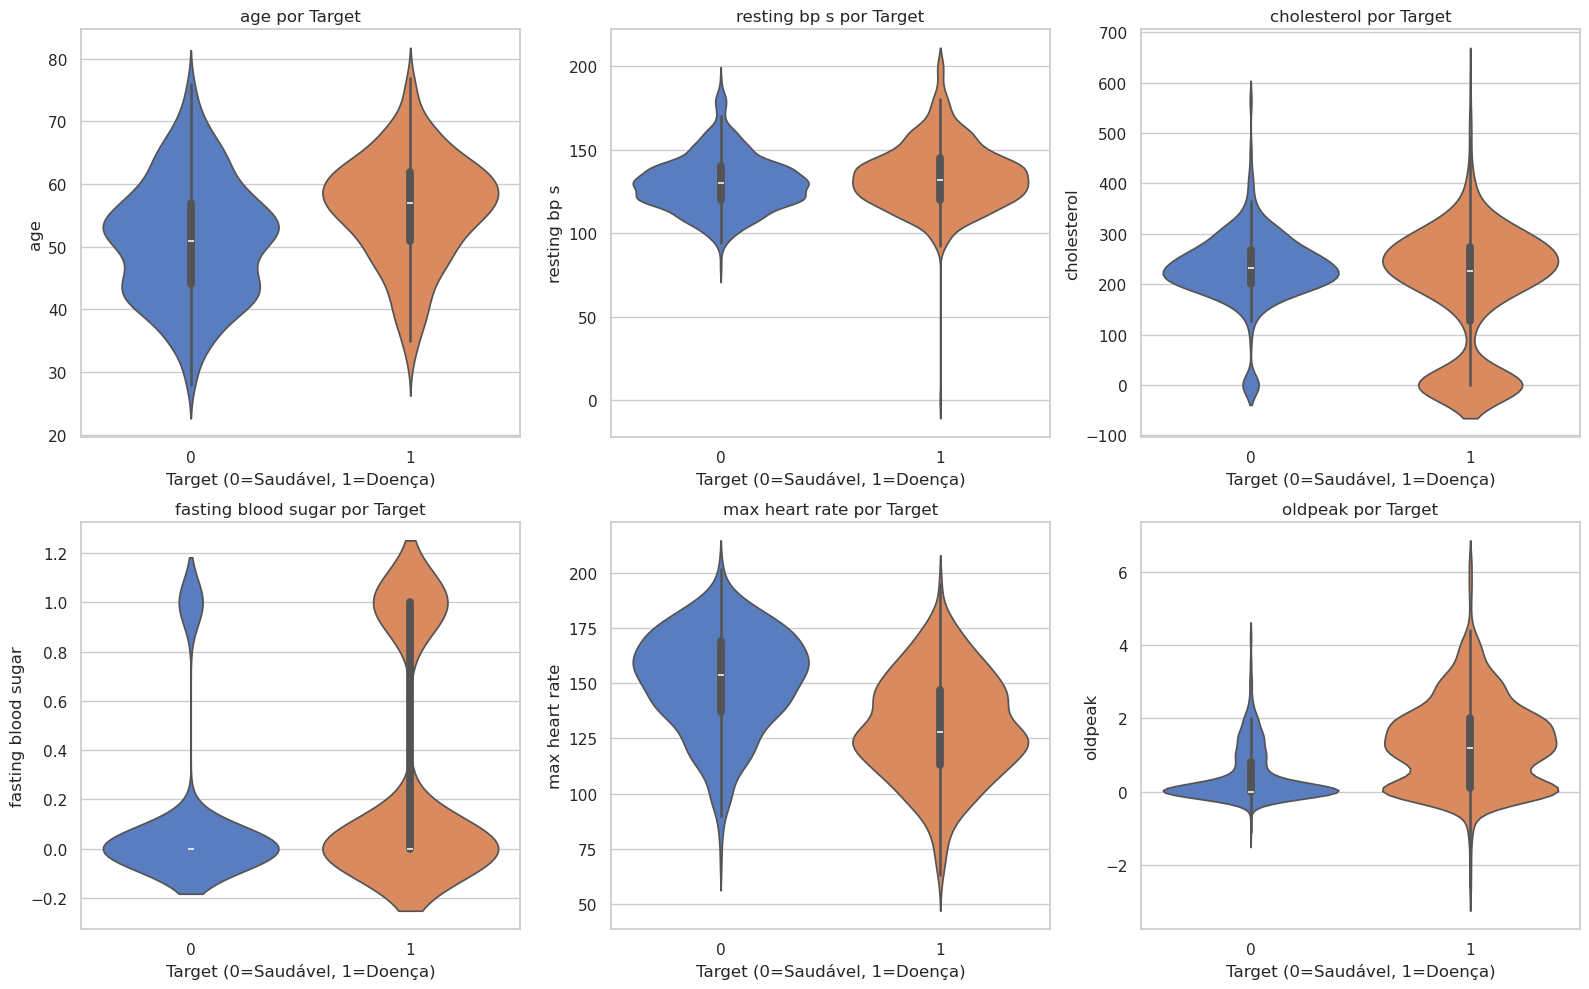

In [24]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(x="target", y=col, data=df, palette="muted")
    plt.title(f"{col} por Target")
    plt.xlabel("Target (0=Saudável, 1=Doença)")
    plt.ylabel(col)
plt.tight_layout()
plt.show()

### KDE plots

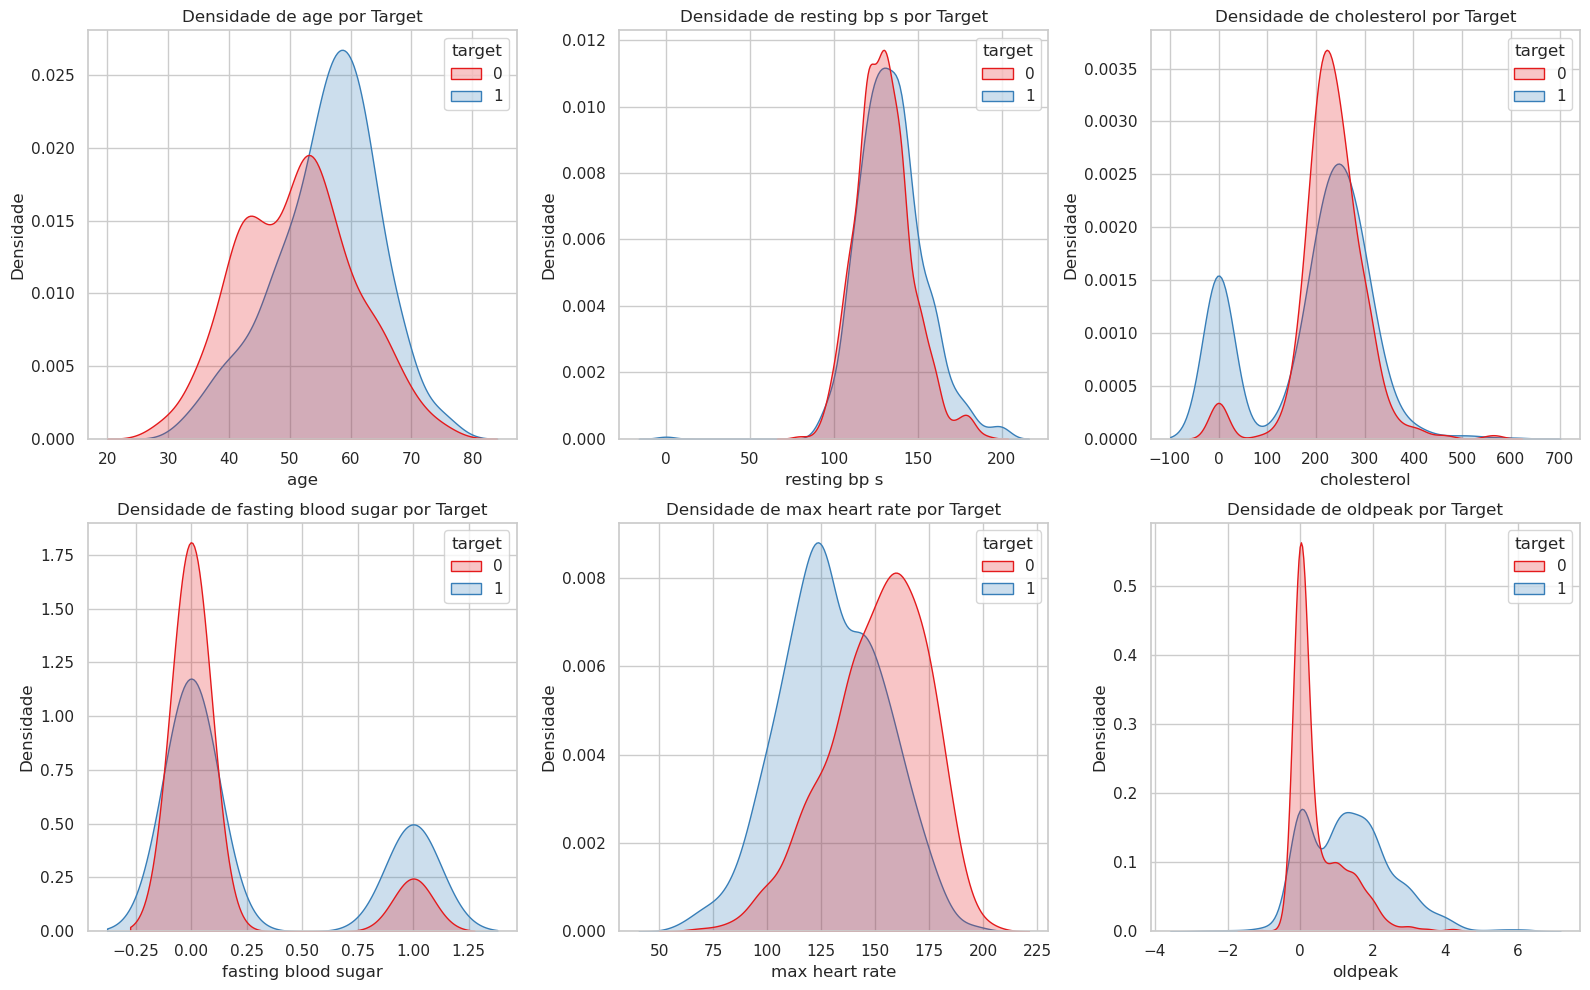

In [25]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(data=df, x=col, hue="target", fill=True, palette="Set1")
    plt.title(f"Densidade de {col} por Target")
    plt.xlabel(col)
    plt.ylabel("Densidade")
plt.tight_layout()
plt.show()

## Pairplot (Features Numéricas)


⏳ Gerando pairplot (pode demorar)...


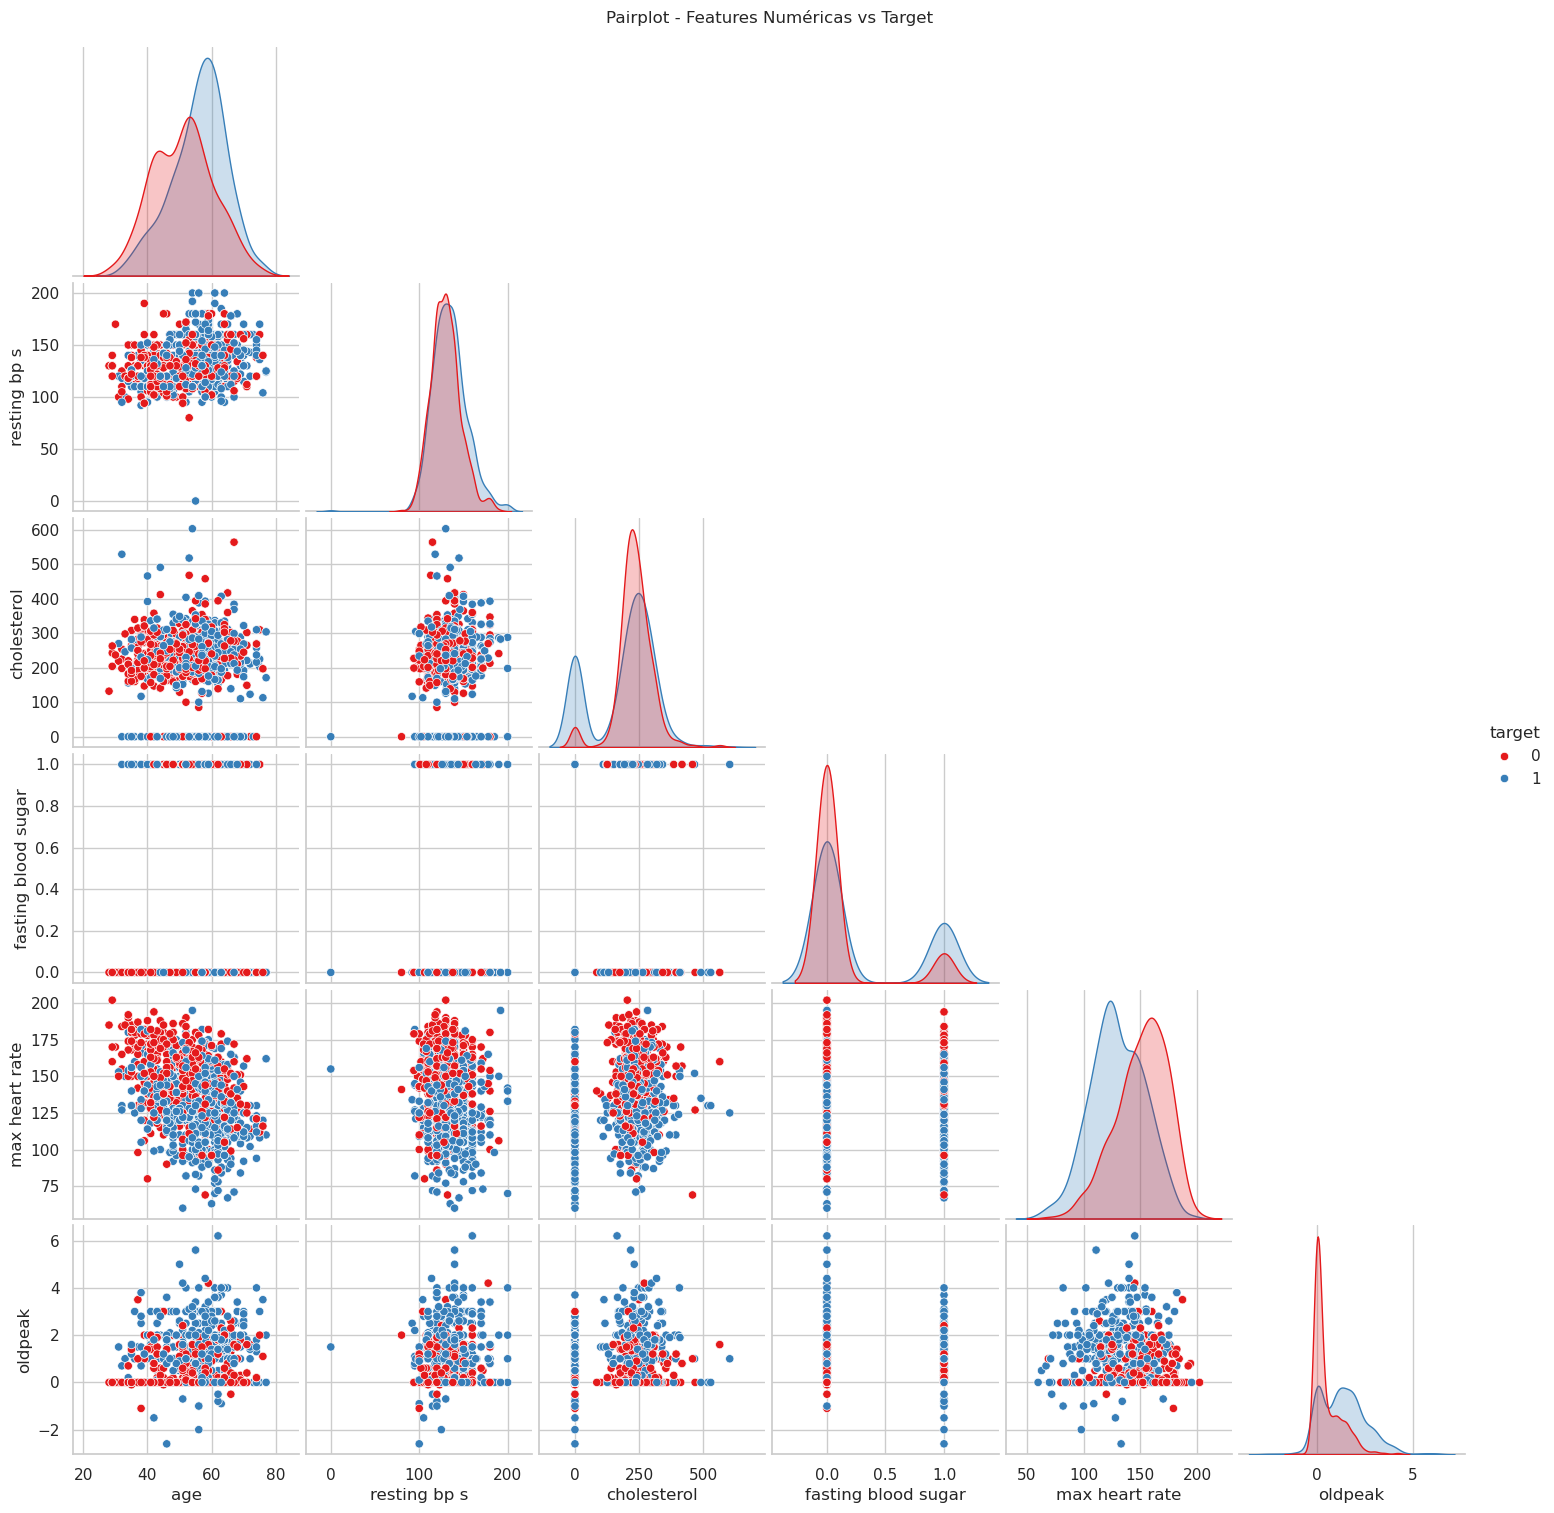

In [26]:
print("\n⏳ Gerando pairplot (pode demorar)...")
sns.pairplot(df[numerical_cols + ["target"]], hue="target", palette="Set1", corner=True)
plt.suptitle("Pairplot - Features Numéricas vs Target", y=1.01)
plt.show()

📝 Resumo das Descobertas

⚠️ Problemas Identificados:
1. **Duplicatas**: 272 linhas (23% dos dados) → Remover
2. **Valores impossíveis**:
   - `resting bp s = 0`: 1 registro → Substituir por mediana
   - `cholesterol = 0`: 172 registros (14.45%) → Substituir por mediana
3. **Outliers**: Detectados mas fisiologicamente possíveis → Manter

✅ Características Positivas:
1. **Sem valores nulos**
2. **Classes balanceadas**: 55% vs 45%

# Salvar no PostgreSQL

In [27]:
# Conectar ao PostgreSQL e salvar estatísticas básicas
db = DatabaseClient()

# Estatísticas básicas para documentação
stats = {
    'total_samples': len(df),
    'total_features': len(df.columns),
    'duplicates': n_duplicates,
    'impossible_values': sum([r['total_impossiveis'] for r in resultados.values()]),
    'class_0': int(target_counts[0]),
    'class_1': int(target_counts[1])
}

print("\n📊 Estatísticas do Dataset:")
for key, value in stats.items():
    print(f"   {key}: {value}")

INFO:src.db_utils:Database Client inicializado: postgres:5432/mlflow_db



📊 Estatísticas do Dataset:
   total_samples: 1190
   total_features: 12
   duplicates: 272
   impossible_values: 173
   class_0: 561
   class_1: 629
